In [1]:
from matplotlib import pylab as plt
from tqdm import tqdm
from skcosmo.decomposition import PCovR
from rascal.representations import SphericalInvariants
from rascal.utils import dump_obj, load_obj
import numpy as np
import ase
from ase.io import read, write

In [2]:
def get_features(atoms_objects, batch_size=1000, progress_bar=True):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        This requires soap to be set.
    '''
    struct_feat=[] #create empty feature vector of n_structures x n_features
    got_frame = False
    for frm in atoms_objects:
        if got_frame == False: 
            if all(sp in frm.get_atomic_numbers() for sp in [1,6,7,8]) == True:
                all_species = frm
                got_frame = True
    for i in tqdm(range(int(len(atoms_objects)/batch_size+0.9999)), disable = not progress_bar, leave=False): #Get feature vectors in batches of 1000
        for frm in atoms_objects[i*batch_size:(i+1)*batch_size]:
            frm.wrap(eps=1e-13) #wrap atoms in unit cell
        frames=[all_species.copy()] #add initial frame with all species
        frames.extend(atoms_objects[i*batch_size:(i+1)*batch_size]) #extend initial frame with frames of batch
        manager = soap.transform(frames) #calculate soap features for all structures in batch
        env_feat_batch = manager.get_features(soap)[len(all_species):] #get feature vectors for all structures in batch
        # (having removed the initial frame)
        atom_counter=0 #count atoms
        for ifrm,frm in enumerate(atoms_objects[i*batch_size:(i+1)*batch_size]): #iterate over frames in batch
            nat=len(frm) #count atoms in frame
            struct_feat.append(np.mean(env_feat_batch[atom_counter:atom_counter+nat],axis=0)) #average vectors
            # for atoms in the same frame. Done by averaging vectors between atom_counter and atom_counter + nat
            atom_counter+=nat #add atoms to counter
    struct_feat_array=np.asarray(struct_feat)
    return struct_feat_array

In [3]:
#Use very barebone soap hypers
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=4, #cutoff distance in angstroms
              max_radial=6, #no. of radial basis functions
              max_angular=4, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=2
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False #don't care about forces right now
              )
soap = SphericalInvariants(**hypers)

In [4]:
train_set = np.load('raw_data/CSD-10k_train_set.npy', allow_pickle=True)
csd_1k = read('raw_data/CSD-1k_combined.xyz', ':')

In [5]:
#Only get HCNO structures
test_set = []
for frm in csd_1k:
    X_frm = [len(np.where(frm.get_atomic_numbers() == sp)[0]) for sp in [1,6,7,8]]
    if len(frm) == sum(X_frm):
        test_set.append(frm)
print(f"Total number of HCNO structures: {len(test_set)}")
print(f"Total number of atoms: {sum([len(frm) for frm in test_set])}")

Total number of HCNO structures: 1000
Total number of atoms: 126380


In [6]:
crystals = []
for frm in train_set:
    frm.info['crystal'] = frm.info['name'].split('_')[0]
    crystals.append(frm.info['crystal'])

len(np.unique(crystals))    

2238

In [7]:
train_set_feats = get_features(train_set, batch_size=500)

In [8]:
test_set_feats = get_features(test_set, batch_size=500)

In [10]:
train_set_feats = train_set_feats - train_set_feats.mean()
train_set_feats = train_set_feats / np.abs(train_set_feats).max()

test_set_feats = test_set_feats - test_set_feats.mean()
test_set_feats = test_set_feats / np.abs(test_set_feats).max()

In [24]:
pca = PCovR(mixing=1, n_components=2)
pca.fit(train_set_feats, y=[])

In [20]:
import chemiscope
from sklearn.decomposition import PCA
import ase.io

pca = PCA(n_components = 4)

frames = train_set.tolist() + test_set
properties = {
    "PCA": pca.fit_transform(np.vstack([train_set_feats, test_set_feats])),
    "training": [1] * train_set_feats.shape[0] + [0] * test_set_feats.shape[0]
    #"PCA_test" : pca.fit_transform(test_set_train_set_featsfeats)
}

widget = chemiscope.show(frames, properties)
widget

/home/vprincip/code/miniconda3/envs/genshift/lib/python3.10/site-packages/chemiscope/structures.py:221: UserWarning: the following atomic properties properties are only defined for a subset of frames: ['PBE-D2_forces', 'forces']; they will be ignored
  warnings.warn(
/home/vprincip/code/miniconda3/envs/genshift/lib/python3.10/site-packages/chemiscope/structures.py:278: UserWarning: the following structure properties properties are only defined for a subset of frames: ['Name', 'PBE-D2_energy', 'crystal', 'energy', 'kpts', 'length_unit', 'name']; they will be ignored
  warnings.warn(


ChemiscopeWidget(value=None, data='{"meta": {"name": " "}, "structures": [{"size": 76, "names": ["C", "C", "C"…

In [52]:
train_set_feats[0, :3], properties["PCA"][0, :3]

(array([0.28985802, 0.00218565, 0.00110135]),
 array([-0.0985966 , -0.14036787,  0.02102834]))

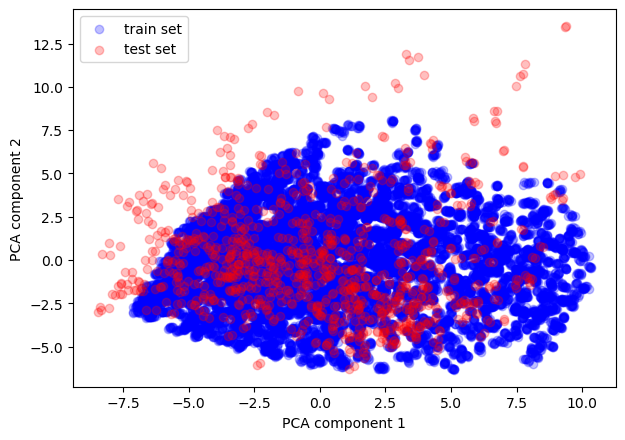

In [120]:
plt.figure(figsize=(7,5), dpi=100)
plt.scatter(properties['PCA_train'][:20000, 0], properties['PCA_train'][:20000, 1], alpha=0.25,
            color='blue', label='train set')
plt.scatter(properties['PCA_test'][:5000, 0], properties['PCA_test'][:5000, 1], alpha=0.25,
            color='red', label='test set')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.legend()

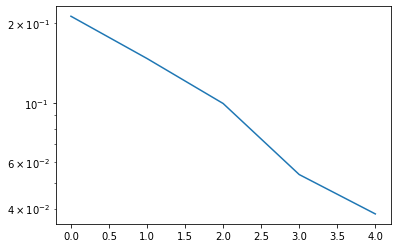

In [98]:
plt.semilogy(pca.explained_variance_ratio_)

In [102]:
properties = {
    "PCA_test" : pca.fit_transform(test_set_feats)
}

In [106]:
frames = test_set
widget = chemiscope.show(frames, properties)

In [108]:
widget

ChemiscopeWidget(value=None, data='{"meta": {"name": " "}, "structures": [{"size": 124, "names": ["N", "N", "O…

## Try kernel PCA

In [25]:
from sklearn.decomposition import KernelPCA
from skcosmo.preprocessing import KernelNormalizer

In [20]:
all_feats = np.append(train_set_feats, test_set_feats, axis=0)

In [22]:
K = np.dot(all_feats, all_feats.T)

In [23]:
K.shape

(23618, 23618)

In [26]:
Kn = KernelNormalizer().fit_transform(K)

In [27]:
kpca = KernelPCA(kernel='precomputed', n_components=2)
kpca.fit(Kn)
t_kpca = kpca.transform(Kn)

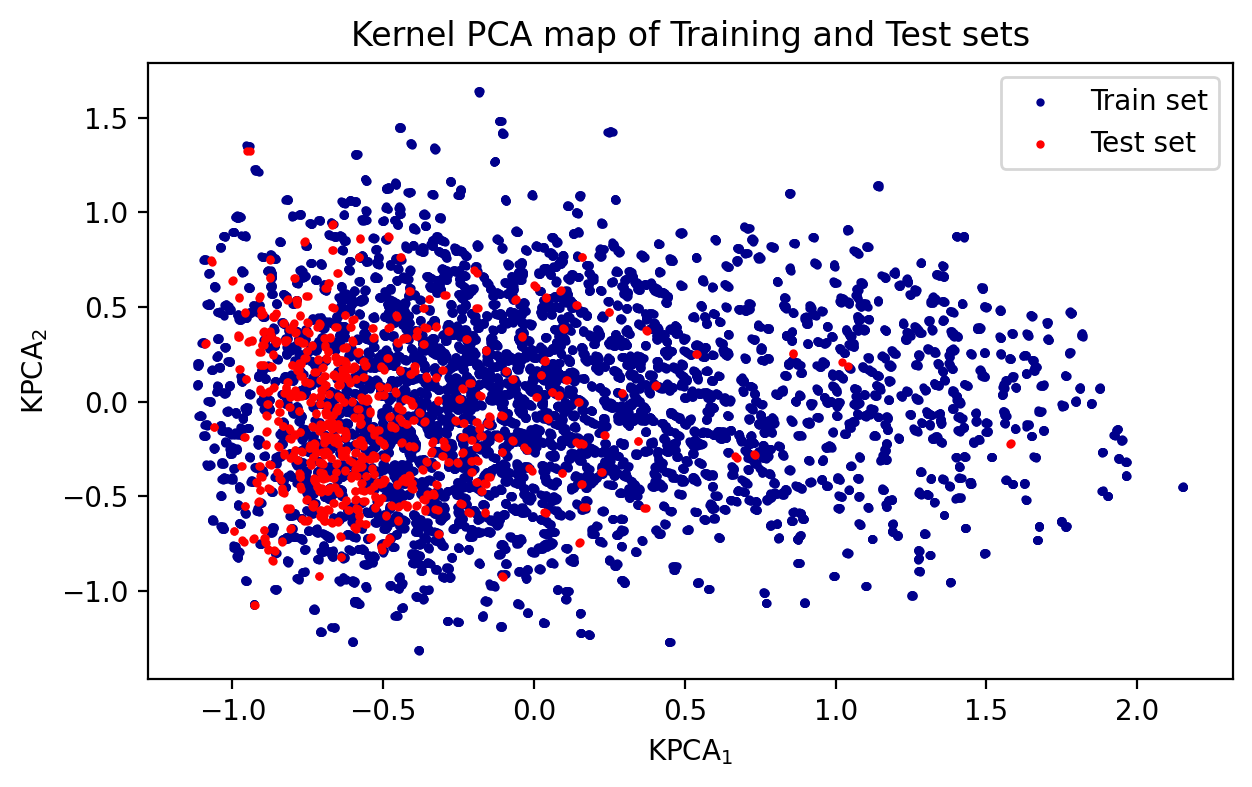

In [50]:
fig, ax = plt.subplots(1, figsize=(7,4), dpi=200)
ax.scatter(t_kpca[:-1000, 0],
                      t_kpca[:-1000, 1],
                      c="darkblue",
                      s=4,
                      vmin=-473.6,
                      vmax=-473.3,
                      rasterized=True,
                      label='Train set')
ax.scatter(t_kpca[-1000:, 0],
                      t_kpca[-1000:, 1],
                      c='red',
                      s=4,
                      vmin=-473.6,
                      vmax=-473.3,
                      rasterized=True,
                      label='Test set')
ax.set_xlabel('$\mathrm{KPCA}_1$')
ax.set_ylabel('$\mathrm{KPCA}_2$')
ax.legend()
ax.set_title('Kernel PCA map of Training and Test sets')
plt.savefig('figures/KPCA_map_train_test_sets.png')

In [29]:
t_kpca.shape

(23618, 2)